In [2]:
from session_validation.validation_submission_workflow import validation_execution
from session_validation.session_params import SessionParams
from session.session import Session
from utils.util_functions import get_updated

config = SessionParams.config_5_tune
config['training_config']['epochs'] = 10

session, validation_df = validation_execution(**config)

In [ ]:
pred_ts, true_ts = session.get_predictions_as_ts()

In [ ]:
from cup_scripts.metric import fscore_step_detection
from utils.util_functions import transform_predictions_to_ts

y_pred = transform_predictions_to_ts(y_pred=pred_ts)
y_true = transform_predictions_to_ts(y_pred=true_ts)

fscore_step_detection(y_true, y_pred)
# (0.9512374047012664, 0.9466925007267342, 0.9563207158839309)
# (0.9450881034478071, 0.938325778809582 , 0.9524791300158627)

(0.6096502609105494, 0.6040473311397649, 0.6163918647082719)

In [ ]:
from typing import List
import numpy as np

def get_metrics(steps: List[List[int]]):
    """_summary_

    Args:
        steps (List[List[int]]): The list of predicted steps per time series [[1,4],[8,21],[213,231]]
        contains list with start and end index
    """

    number_of_detected_steps = len(steps)
    step_lengths = [None] * number_of_detected_steps

    step_offsets = [None] * (number_of_detected_steps - 1)

    for i in range(number_of_detected_steps):
        step_start, step_end = steps[i]
        length = step_end - step_start
        step_lengths[i] = length

        # get the step before to calculate the last offset
        if i != 0 :
            step_before_start, step_before_end = steps[i - 1]
            step_offset = step_start - step_before_end
            step_offsets[i -1] = step_offset

    return step_lengths, step_offsets



In [ ]:
def join_with_before(steps,i):

    (start,end) = steps[i]
    (start_before,end_before) = steps[i - 1]

    joined_start, joined_end = start_before, end
    steps[i] = [joined_start, joined_end]
    del steps[i-1]
    return steps

def join_steps(steps: List[List[int]], 
        offset_quantile = 0.25, 
        length_quantile = 0.25, 
        small_offset_quantile = 0.2, 
        small_length_quantile = 0.2
):


    step_lengths, step_offsets = get_metrics(steps=steps)
    steps_length_avg = np.average(step_lengths)
    steps_offset_avg = np.average(step_offsets)

    step_length_quantile, small_step_length_quantile= steps_length_avg * length_quantile, steps_length_avg * small_length_quantile
    step_offset_quantile, small_step_offset_quantile = steps_offset_avg * offset_quantile, steps_offset_avg * small_offset_quantile
    
    for i in range(len(steps)):

        (start,end) = steps[i]
        step_length = end - start

        if i == 0: continue
        (start_before,end_before) = steps[i - 1]

        step_offset = start - end_before
        step_before_length = end_before - start_before

        # two smaller steps get merged to one
        if (step_offset < step_offset_quantile 
            and step_before_length < step_length_quantile
            and step_length < step_length_quantile
        ):
            return join_with_before(steps=steps,i=i), True

        # the first step is very small, the second is normal size
        if (step_offset < small_step_offset_quantile 
            and step_before_length < small_step_length_quantile
        ):
            return join_with_before(steps=steps,i=i), True

        # the first step is normal, the second is very small
        if (step_offset < small_step_offset_quantile 
            and step_length < small_step_length_quantile
        ):
            return join_with_before(steps=steps,i=i), True

            
    return steps, False

In [ ]:
from copy import copy
import numpy as np

from utils.util_functions import CustomBar

def join_dataset_test(length_quantile, offset_quantile, small_offset_quantile, small_length_quantile):
    y_pred_new = [None] * len(y_pred)

    for i in range(len(y_pred)):
        #print(i)
        y = y_pred[i]
        ys = copy(y)

        while True:
            ys, change = join_steps(ys, 
                length_quantile=length_quantile, 
                offset_quantile=offset_quantile,
                small_offset_quantile=small_offset_quantile,
                small_length_quantile=small_length_quantile,


            ) 
            if not change: break

        y_pred_new[i] = ys

    f_score, _ , _ = fscore_step_detection(y_true, y_pred_new)

    return f_score, y_pred_new

0.0
[[0.63057875]]


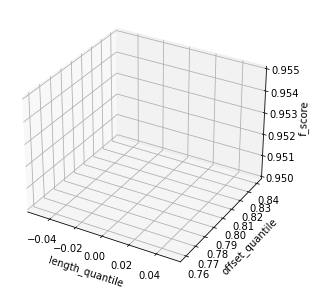

In [ ]:
from copy import copy
import numpy as np

from utils.util_functions import CustomBar

count = 1
rX = [0.00,1.0]
rY = [0.8,1.2]
X = np.arange(rX[0],rX[1], (rX[1] - rX[0]) / count)
Y = np.arange(rY[0],rY[1], (rY[1] - rY[0]) / count)
Z = np.array([0.0] * count * count ).reshape((count,count))
bar =  CustomBar('Calculating values', max=count*count)

length_quantile=0.083333
offset_quantile=0.048333

small_length_quantile=0.4564
small_offset_quantile=0.6944 # 0.7 was max value -> improvement possible
for i in range(count):
    for j in range(count):
        
        x = float(X[i])
        y = float(Y[j])
        z, _ = join_dataset_test(
            length_quantile=x, 
            offset_quantile=y,
            small_length_quantile=small_length_quantile,
            small_offset_quantile=small_offset_quantile
        )

        # print(f'{i},{j}: {z}')
        Z[i,j] = z

        bar.next()
    print(round((i*(count) + j) / (count * count),ndigits=4))

X, Y = np.meshgrid(X, Y)
print(Z)

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax.view_init(azim=0, elev=90)
ax.set_xlabel(r'length_quantile')
ax.set_ylabel(r'offset_quantile')
ax.set_zlabel(r'f_score')
ax.set_zlim(0.95, 0.955)
Z[Z<=0.95123] = 0.95123
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



In [ ]:
X = np.arange(rX[0],rX[1], (rX[1] - rX[0]) / count)
Y = np.arange(rY[0],rY[1], (rY[1] - rY[0]) / count)
(y_best,x_best) = np.unravel_index(Z.argmax(), Z.shape)
print(f'length_quantile={round(X[x_best],ndigits=6)}, offset_quantile={round(Y[y_best],ndigits=6)}')
f1, _, _ = fscore_step_detection(y_true, y_pred)
print(f'From: {f1} to {np.max(Z)}, offset = {round((np.max(Z) - f1) * 100,ndigits=4)} % Punkte')


# Für 1. run small parameters: 
#length_quantile=0.4564, offset_quantile=0.6944
#From: 0.9512374047012664 to 0.9528609966524334, offset = 0.1624 % Punkte

# Für 2. run big parameters: 
#length_quantile=0.586667, offset_quantile=1.101333
#From: 0.9512374047012664 to 0.9526462546517871, offset = 0.1409 % Punkte

length_quantile=0.0, offset_quantile=0.8
From: 0.6096502609105494 to 0.95123, offset = 34.158 % Punkte


In [ ]:
from cup_scripts.utils import load_train, load_test
X_train, Y_train, metadata_train = load_train()


In [ ]:
import matplotlib.pyplot as plt
line_args = {"linestyle": "--", "color": "k"}
plt.rcParams["figure.figsize"] = (20,5)

from cup_scripts.metric import fscore_step_detection
from cup_scripts.metric import fscore_step_detection_get_steps

from data_processing.normalization_functions.min_max_symmetrical import min_max_symmetrical


def plot_post_processing(y0_pred, y0_pred_proc, y0_true, x0 = None):
    
    fig, axs = plt.subplots(3)
    fig.suptitle('Vertically stacked subplots')

    ys = [y0_pred, y0_pred_proc, y0_true]

    f1a, _ , _ = fscore_step_detection([y0_true],[y0_pred])
    f1b, _ , _ = fscore_step_detection([y0_true],[y0_pred_proc])

    pre, rec = fscore_step_detection_get_steps([y0_true],[y0_pred]).values()
    pre_true, pre_false = pre
    rec_true, rec_false = rec

    pre_p, rec_p = fscore_step_detection_get_steps([y0_true],[y0_pred_proc]).values()
    pre_true_p, pre_false_p = pre_p
    rec_true_p, rec_false_p = rec_p

    errors_pre = [pre_false[0], pre_false_p[0],[]]
    errors_rec = [rec_false[0], rec_false_p[0],[]]
        
    titles = [f"Prediction: {round(f1a,ndigits=4)}", f"Processed Prediction: {round(f1b,ndigits=4)}", "Ground truth"]
    colors = ["y", "orange", "g"]
    for i in range(3):
        
        error_pre = errors_pre[i]
        for (start,end) in error_pre:
            axs[i].axvline(start, **line_args)
            axs[i].axvline(end, **line_args)
            axs[i].axvspan(start, end, facecolor='r', alpha=0.5, hatch='/')

        error_rec = errors_rec[i]
        for (start,end) in error_rec:
            axs[i].axvline(start, **line_args)
            axs[i].axvline(end, **line_args)
            axs[i].axvspan(start, end, facecolor='r', alpha=0.5, hatch='\\')

        for (start,end) in ys[i]:
            axs[i].set_title(titles[i])
            axs[i].axvline(start, **line_args)
            axs[i].axvline(end, **line_args)
            axs[i].axvspan(start, end, facecolor=colors[i], alpha=0.5)

        if x0 is not None:
            normalized = np.apply_along_axis(min_max_symmetrical,0,x0)
            sum = np.sum(normalized,axis=1)
           
            axs[i].plot(sum )

    plt.tight_layout()
    plt.show()


510


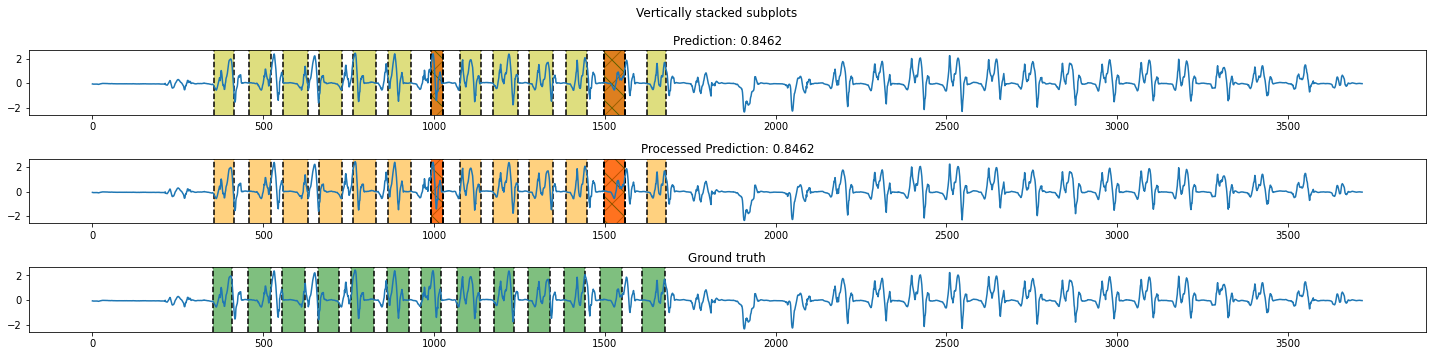

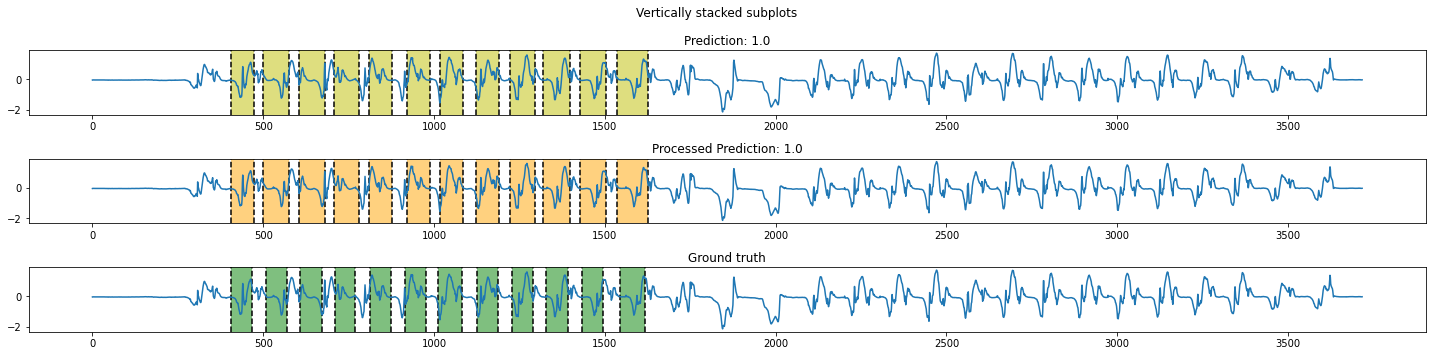

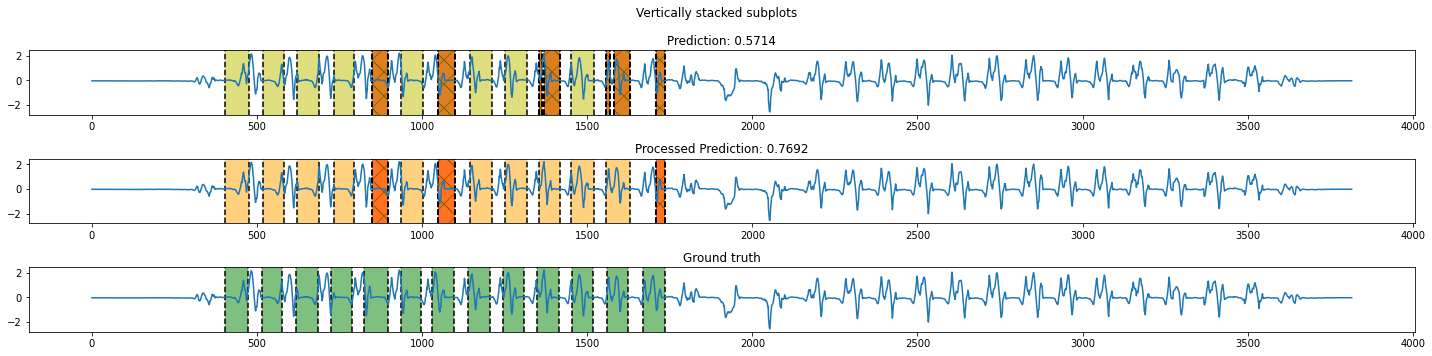

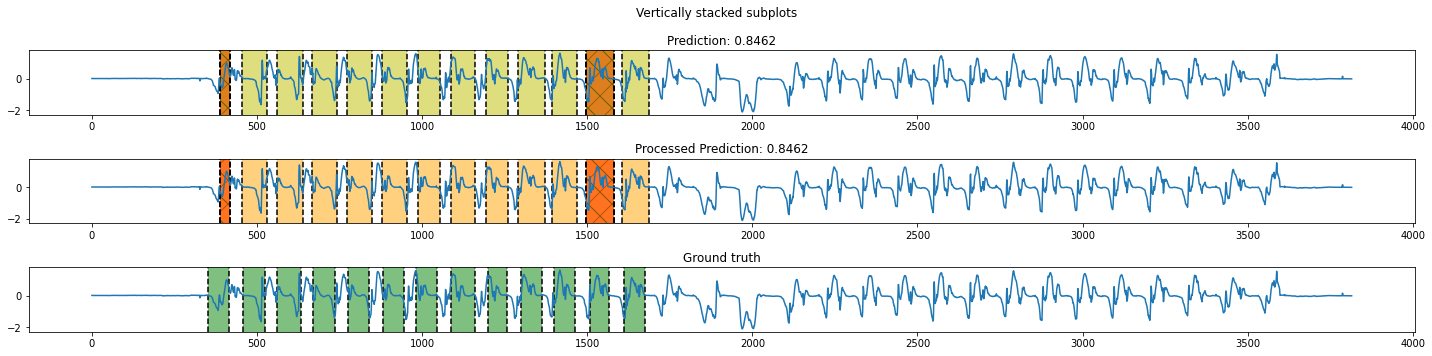

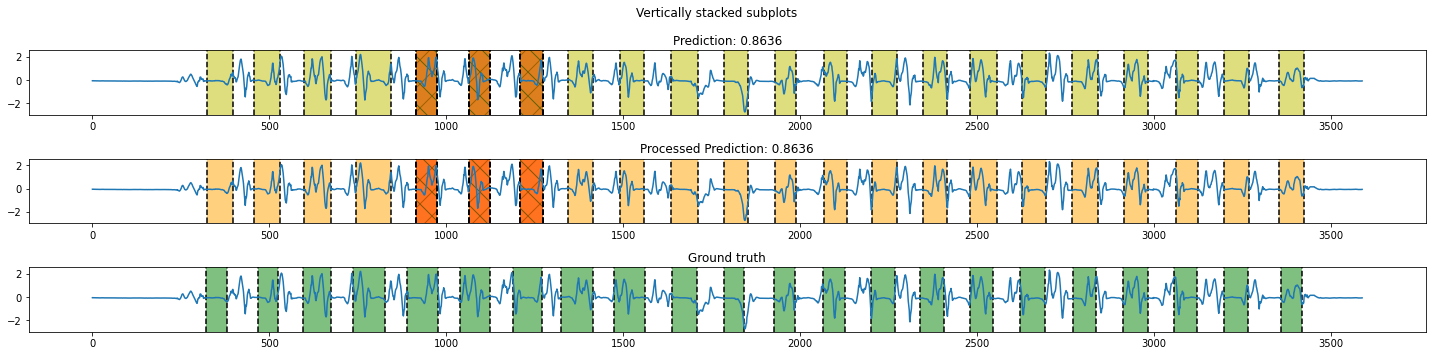

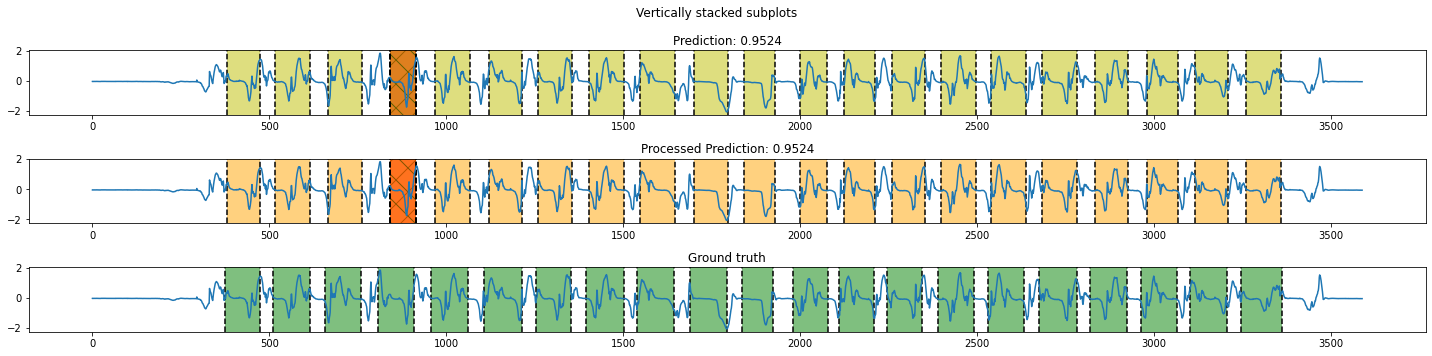

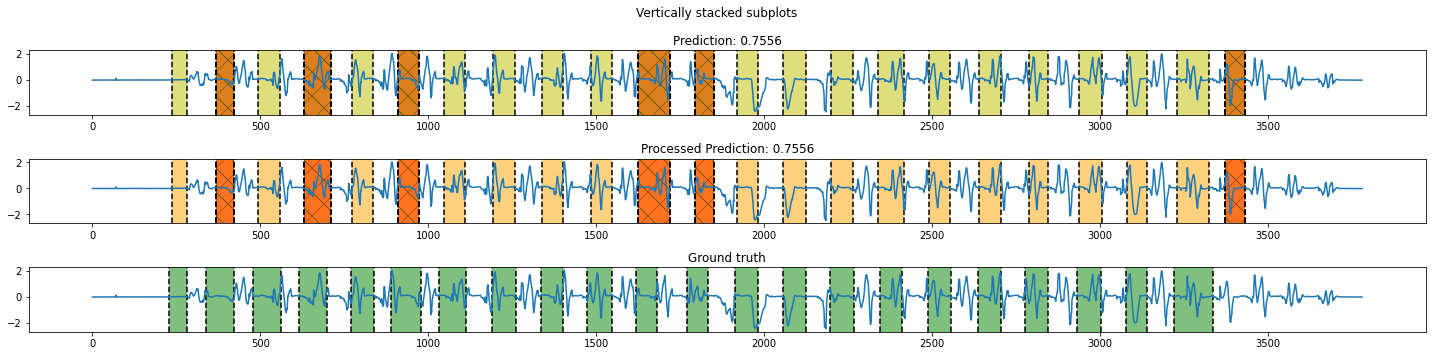

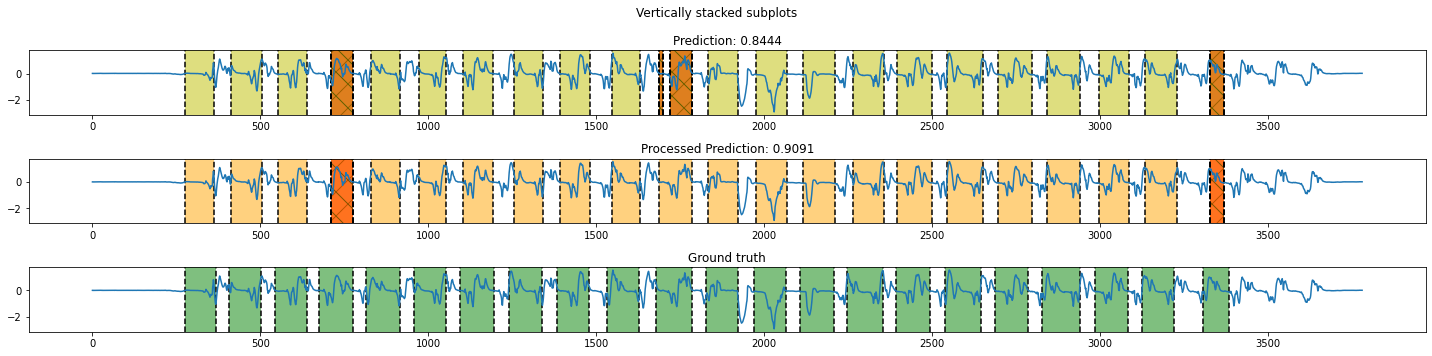

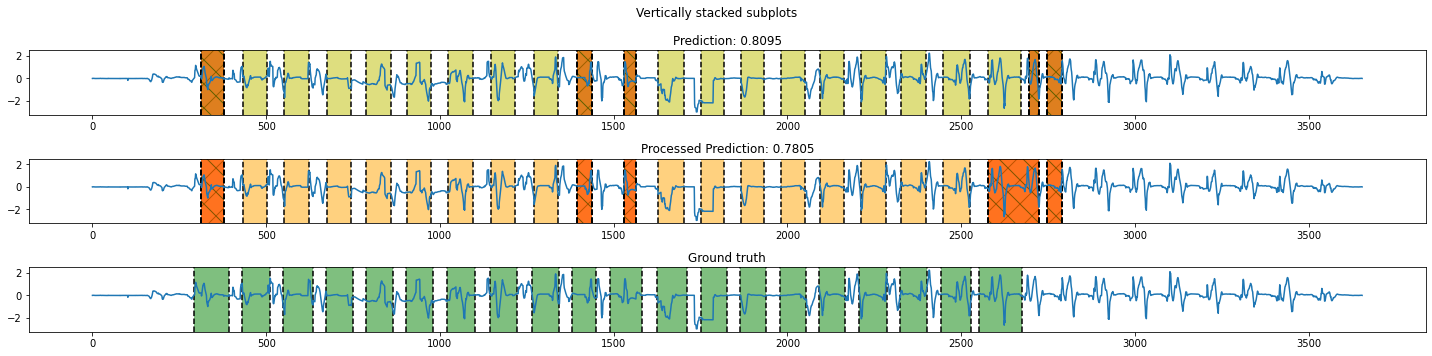

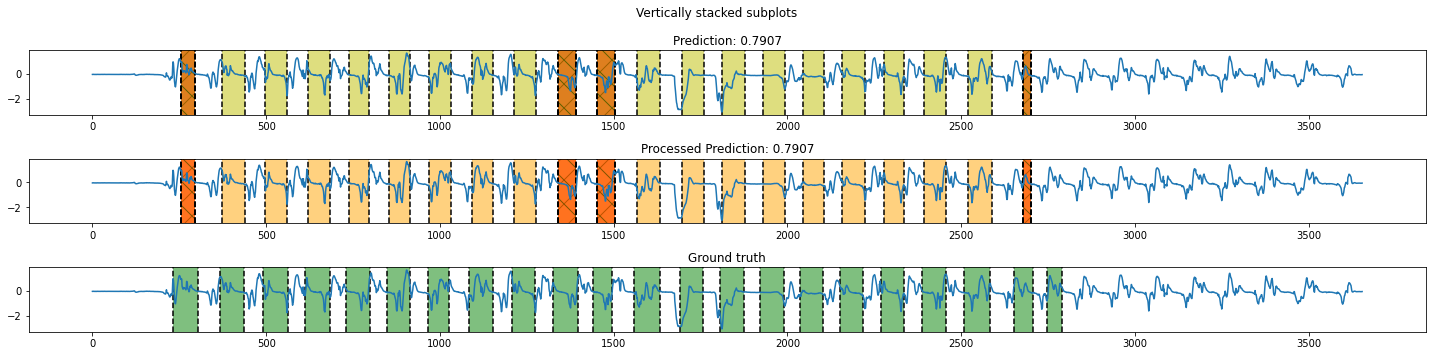

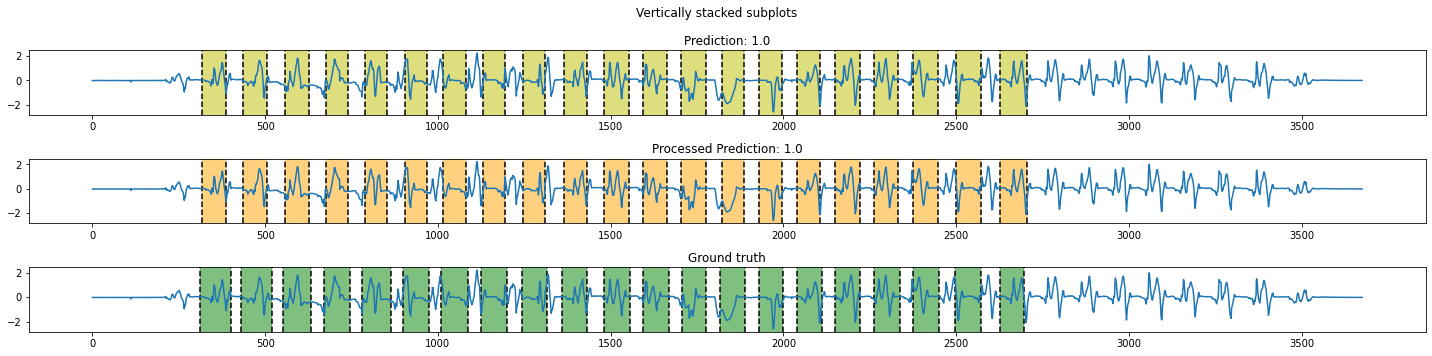

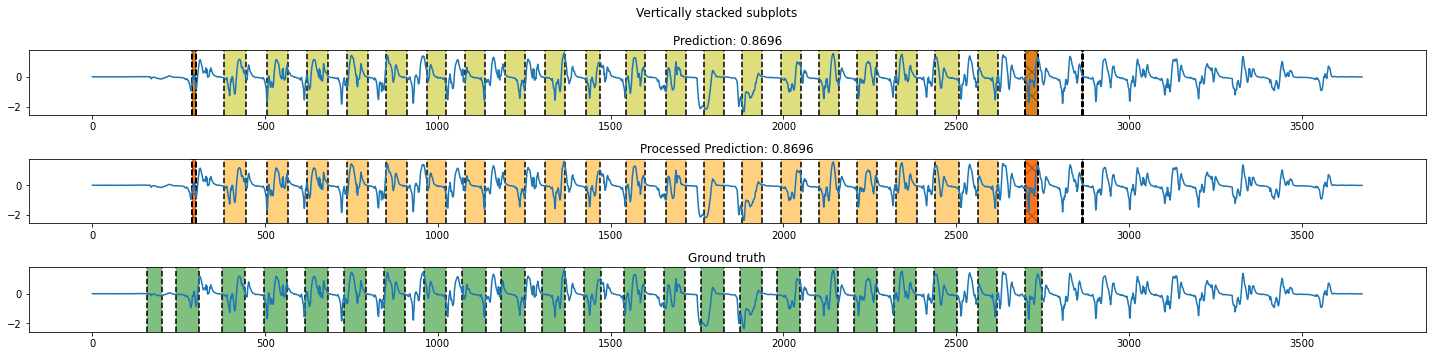

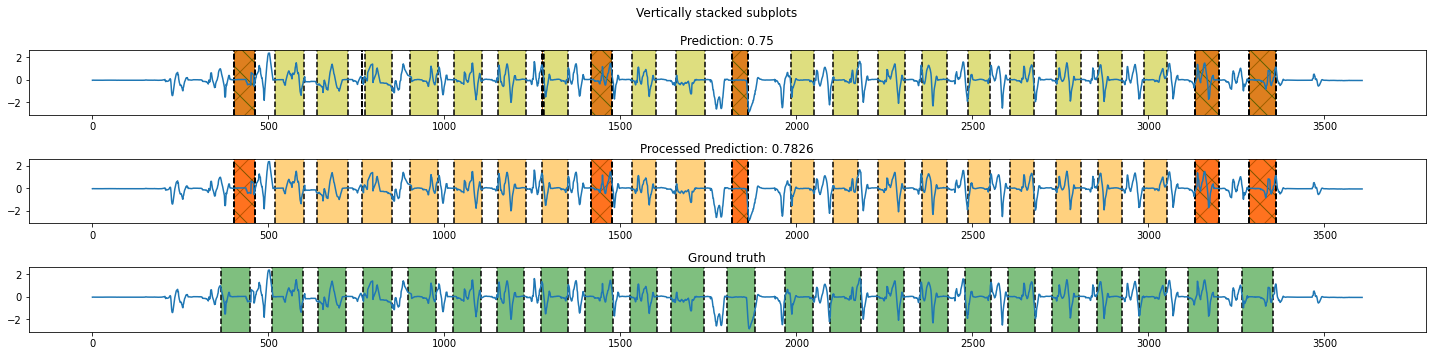

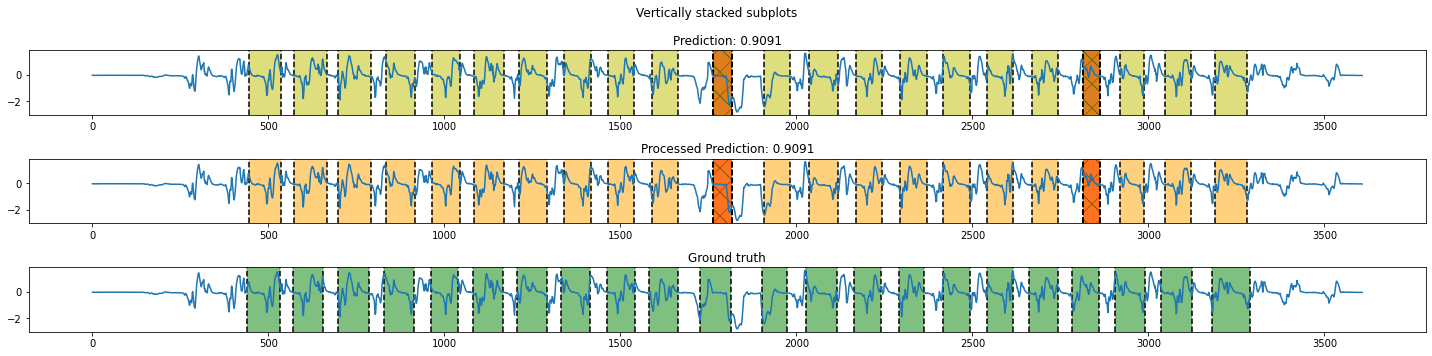

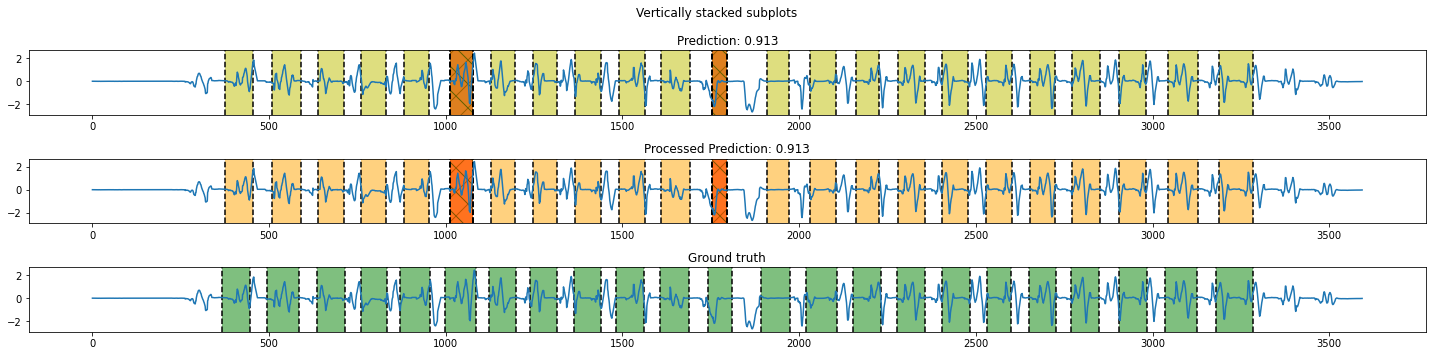

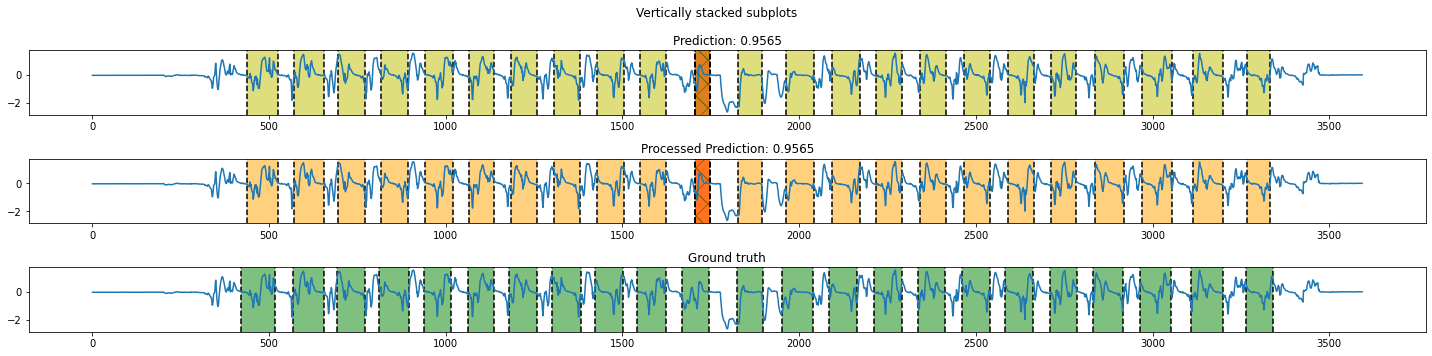

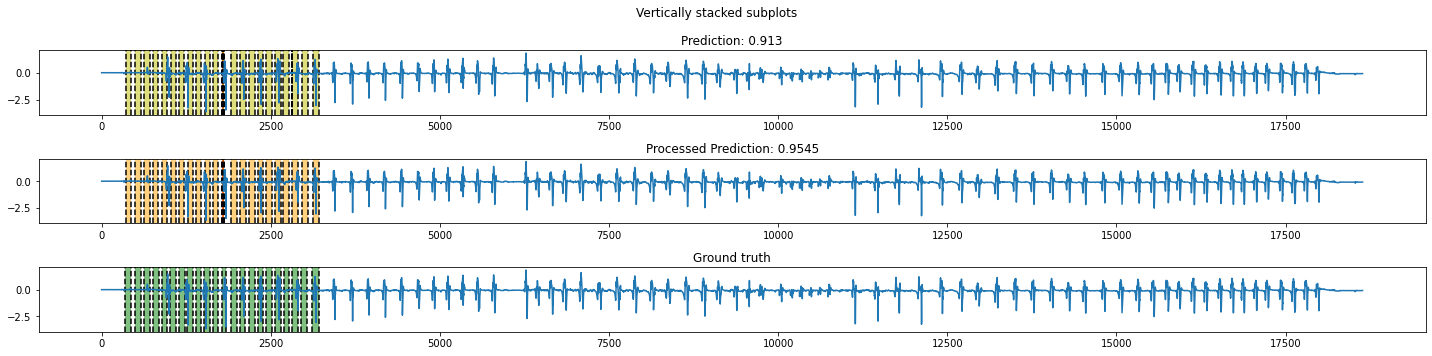

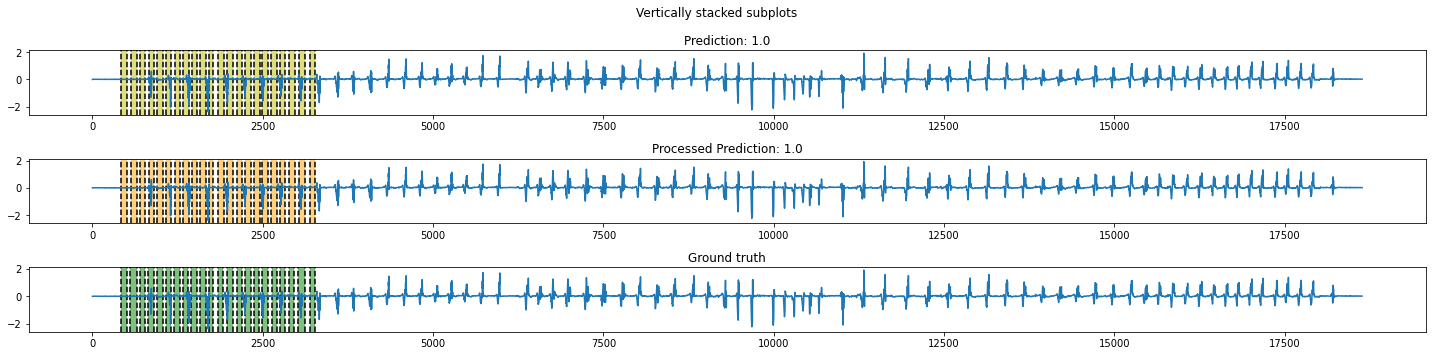

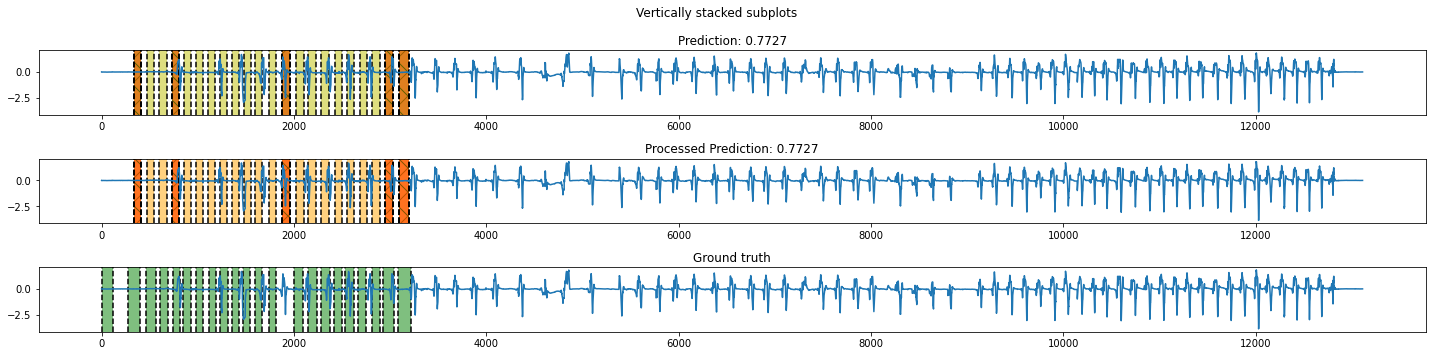

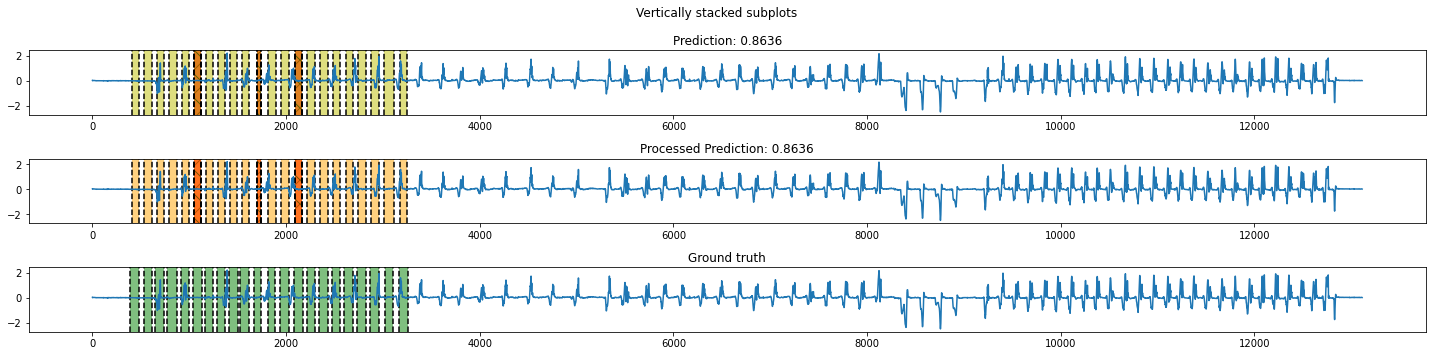

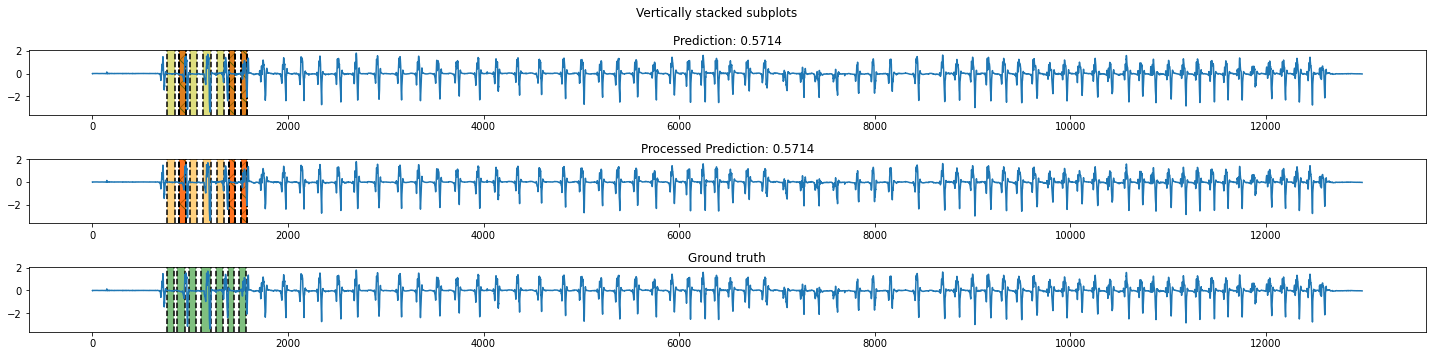

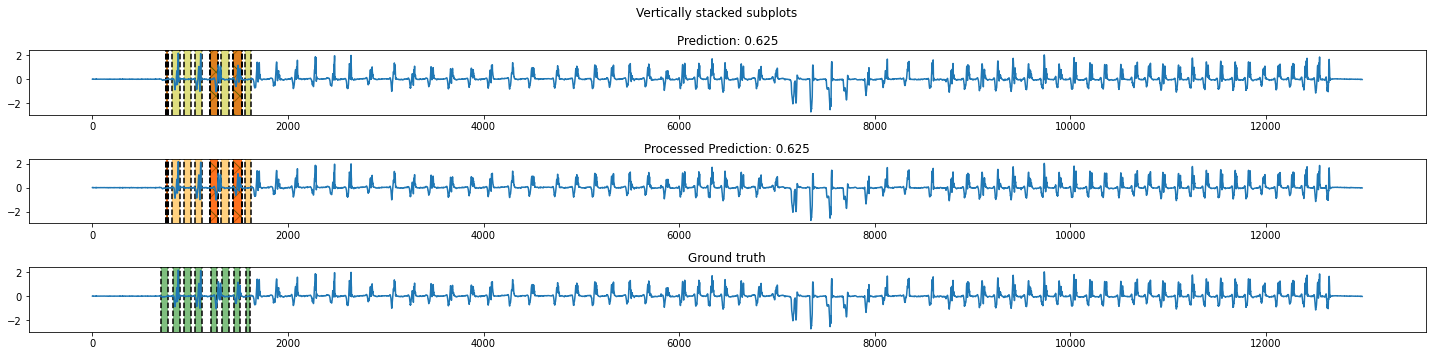

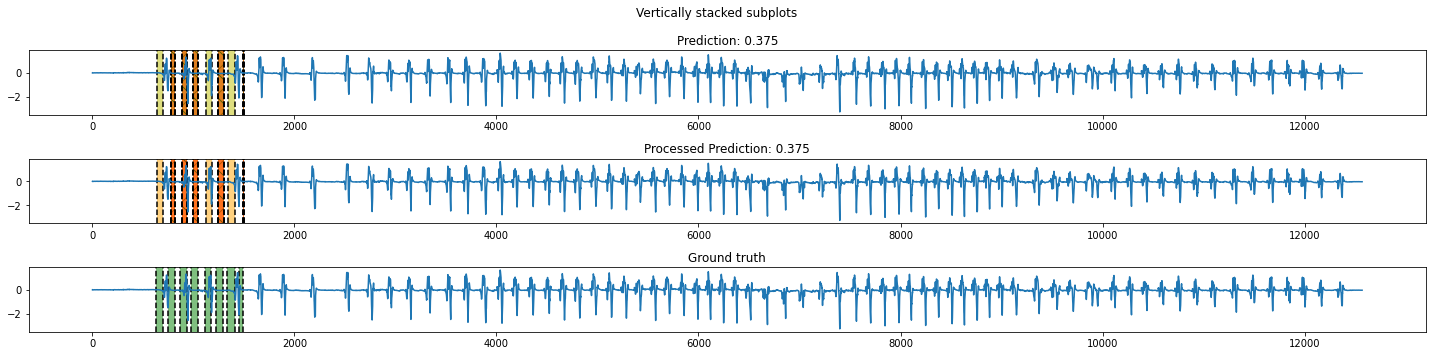

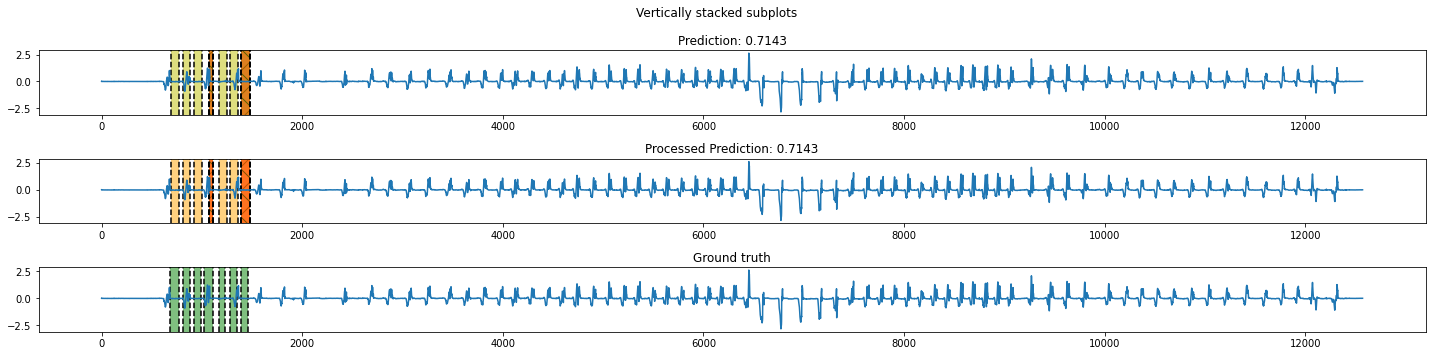

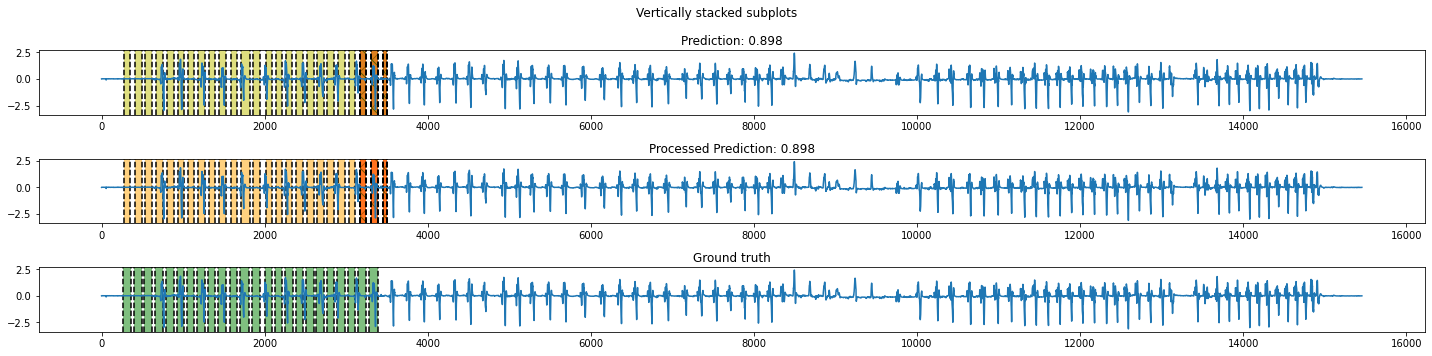

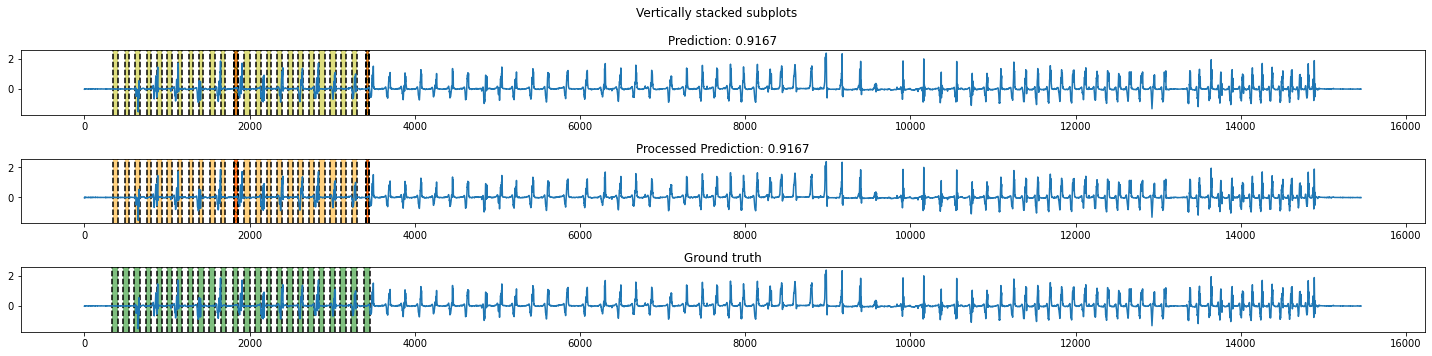

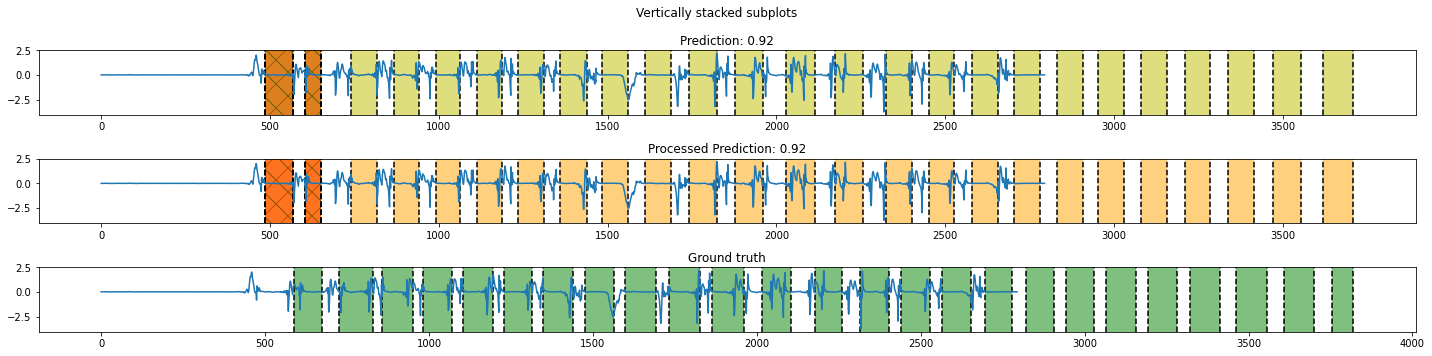

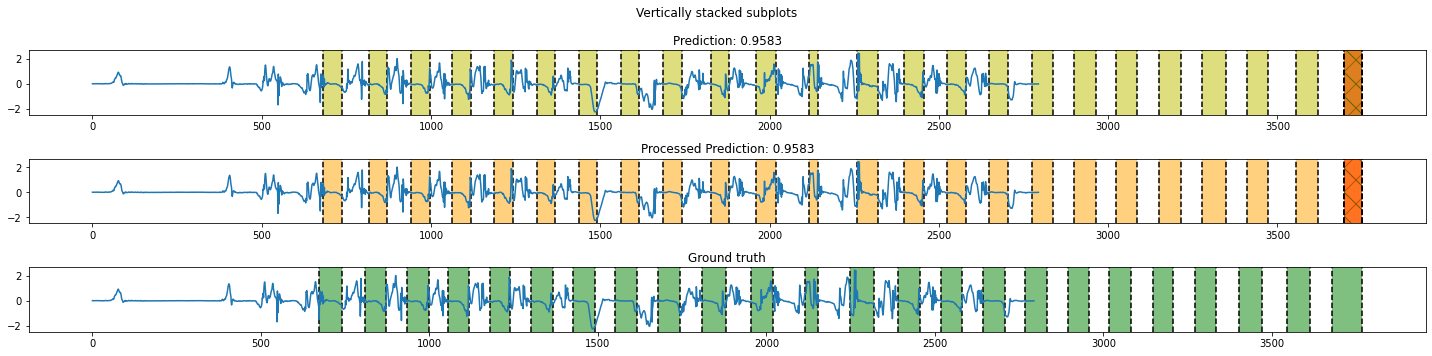

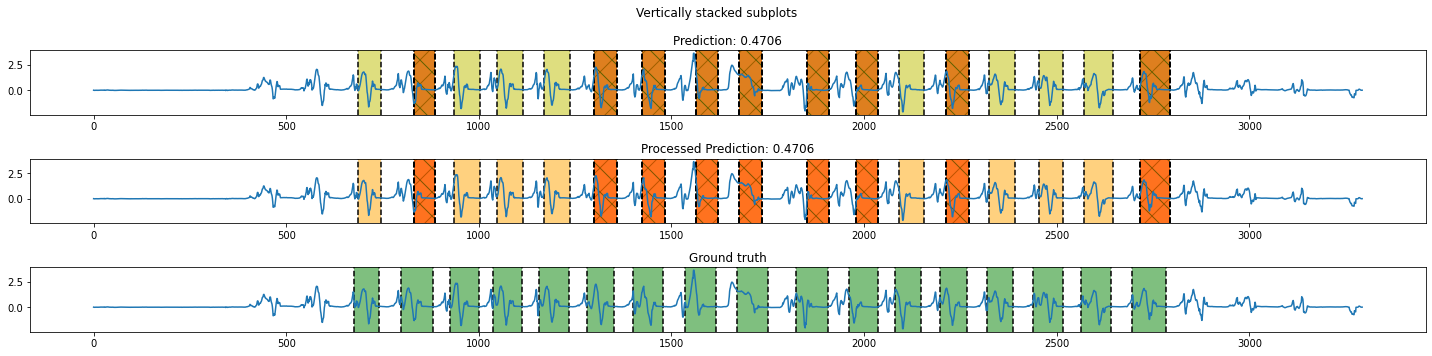

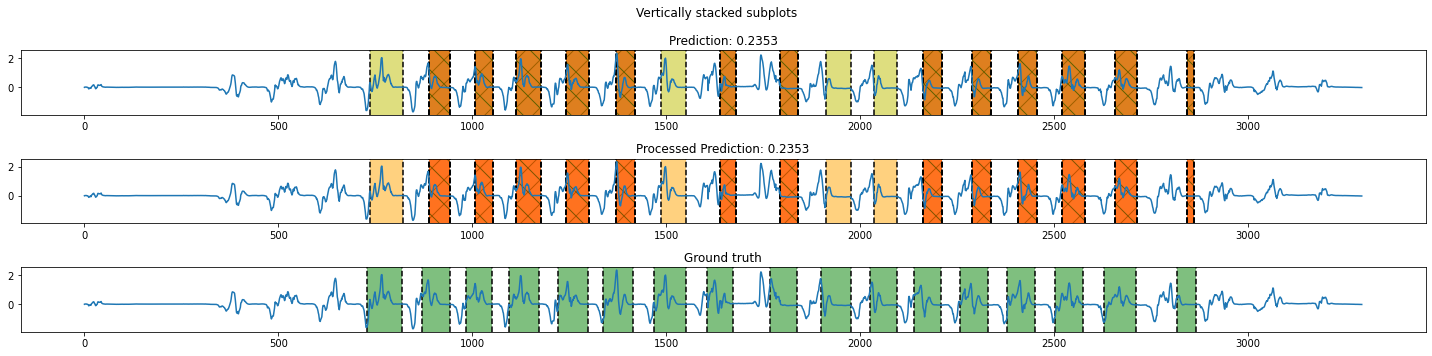

In [ ]:
score, y_pred_2 = join_dataset_test(0.5,0.5,0.7,0.45)
print(len(y_pred_2))
for i in range(40,70,1):
    
    plot_post_processing(y0_pred=y_pred[i], y0_pred_proc=y_pred_2[i], y0_true=y_true[i],x0=X_train[i])